In [1]:
# Setup Environment
%pip -q install tensorflow scikit-learn numpy opencv-python matplotlib seaborn tqdm

# Standard library imports
import os

# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import joblib
from tqdm import tqdm

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, Model

# Scikit-learn imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

You should consider upgrading via the 'c:\Users\anama\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
# Load Dataset
# Set up directory paths for our lung cancer dataset
base_dir = "./lung_image_set"
print("Main folders:", os.listdir(base_dir))

# Define paths to training and test directories
train_dir = os.path.join(base_dir, "Train and Validation Set")
test_dir = os.path.join(base_dir, "Test Set")

# Check what classes we have in each set
print("Train folders:", os.listdir(train_dir))
print("Test folders:", os.listdir(test_dir))

Main folders: ['Test Set', 'Train and Validation Set']
Train folders: ['lung_aca', 'lung_n', 'lung_scc']
Test folders: ['lung_aca', 'lung_n', 'lung_scc']


Train set: {'lung_aca': 4500, 'lung_n': 4500, 'lung_scc': 4501}
Test set: {'lung_aca': 500, 'lung_n': 500, 'lung_scc': 499}


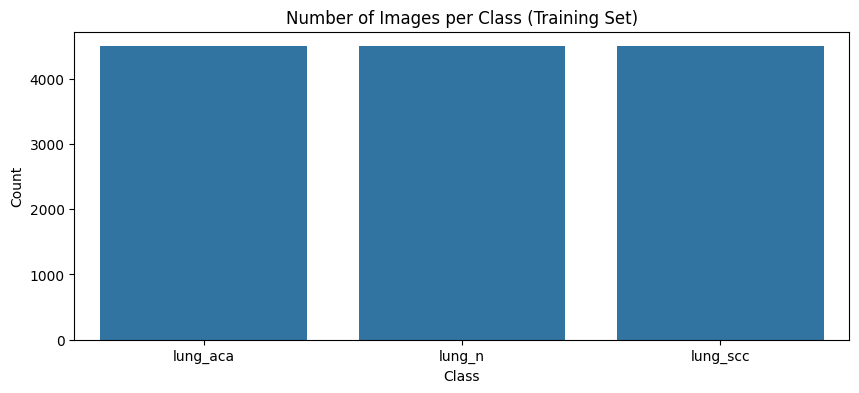

In [ ]:
# Function to count images in each class folder
def count_images_in_folders(directory):
    counts = {}
    for folder in os.listdir(directory):
        folder_path = os.path.join(directory, folder)
        if os.path.isdir(folder_path):
            counts[folder] = len(os.listdir(folder_path))
    return counts

# Count images in training and test sets
train_counts = count_images_in_folders(train_dir)
test_counts = count_images_in_folders(test_dir)

print("Train set:", train_counts)
print("Test set:", test_counts)

# Visualize class distribution in training set
plt.figure(figsize=(10, 4))
sns.barplot(x=list(train_counts.keys()), y=list(train_counts.values()))
plt.title("Number of Images per Class (Training Set)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

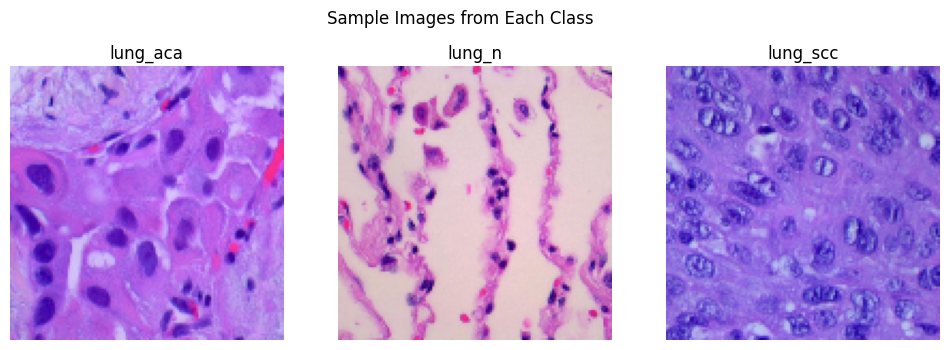

In [ ]:
# Function to display sample images from each class
def visualize_samples(data_dir, class_names, img_size=(128, 128)):
    plt.figure(figsize=(12, 4))
    for i, cls in enumerate(class_names):
        # Get first image from each class folder
        folder = os.path.join(data_dir, cls)
        img_path = os.path.join(folder, os.listdir(folder)[0])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for display
        img = cv2.resize(img, img_size)
        plt.subplot(1, len(class_names), i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis("off")
    plt.suptitle("Sample Images from Each Class")
    plt.show()

# Display sample images from all three lung cancer classes
class_names = ['lung_aca', 'lung_n', 'lung_scc']  # adenocarcinoma, normal, squamous cell carcinoma
visualize_samples(train_dir, class_names)

In [ ]:
# Data Preprocessing & Augmentation
# Set image dimensions and batch size for training
IMG_SIZE = (60, 60)  # Resize all images to 60x60 pixels
BATCH_SIZE = 32      # Process 32 images at a time

# Define data generators with augmentation for training
# Augmentation helps prevent overfitting by creating variations of training images
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values to 0-1 range
    rotation_range=15,        # Random rotation up to 15 degrees
    width_shift_range=0.1,    # Random horizontal shift up to 10%
    height_shift_range=0.1,   # Random vertical shift up to 10%
    shear_range=0.1,          # Random shearing transformation
    zoom_range=0.1,           # Random zoom up to 10%
    horizontal_flip=True,     # Random horizontal flip
    fill_mode='nearest'       # Fill empty pixels with nearest values
)

# Simple preprocessing for test data (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators for training and testing
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # One-hot encode labels
    shuffle=True               # Shuffle training data
)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False              # Don't shuffle test data
)

# Get number of classes and display dataset info
num_classes = len(train_gen.class_indices)
print("Classes:", train_gen.class_indices)
print("Train samples:", train_gen.samples)
print("Test samples:", test_gen.samples)

Found 13501 images belonging to 3 classes.
Found 1499 images belonging to 3 classes.
Classes: {'lung_aca': 0, 'lung_n': 1, 'lung_scc': 2}
Train samples: 13501
Test samples: 1499


In [ ]:
# This CNN architecture is designed for lung cancer classification
def build_cnn(input_shape=(60,60,3)):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        
        # First convolutional block - extract basic features
        layers.Conv2D(32, (4,4), activation='relu', padding='same'),
        layers.BatchNormalization(),  # Normalize activations to help training
        layers.MaxPooling2D((2,2)),    # Reduce spatial dimensions

        # Second convolutional block - extract more complex features
        layers.Conv2D(64, (4,4), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # Third convolutional block - extract high-level features
        layers.Conv2D(84, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # Fourth convolutional block - extract very specific features
        layers.Conv2D(124, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        # Fifth convolutional block - final feature extraction
        layers.Conv2D(124, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        # Global average pooling instead of flatten - reduces overfitting
        layers.GlobalAveragePooling2D(),
        
        # Fully connected layers for classification
        layers.Dense(1000, activation='relu'),           # Feature vector for Random Forest
        layers.Dense(num_classes, activation='softmax') # Final classification layer
    ])
    return model

# Create and compile the CNN model
cnn_model = build_cnn()
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 32)     │         1,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 60, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 64)     │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 15, 15, 84)     │        48,468 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 15, 15, 84)     │           336 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 7, 7, 84)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 124)      │        93,868 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 7, 7, 124)      │           496 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 124)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 124)      │       138,508 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 124)      │           496 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 124)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │       125,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │         3,003 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 444,959 (1.70 MB)

 Trainable params: 444,103 (1.69 MB)

 Non-trainable params: 856 (3.34 KB)

In [10]:
# Train CNN first to get meaningful features
print("Training CNN model...")
cnn_model.fit(train_gen, epochs=1, verbose=1)

# Function to extract features from trained CNN
# This converts images to high-level feature vectors for Random Forest

def extract_features(generator, model):

    features = []

    labels = []

    for _ in tqdm(range(len(generator))):

        x_batch, y_batch = next(generator)

        feat = model.predict(x_batch, verbose=0)  # Get CNN features
        features.append(feat)

        labels.append(y_batch)

    return np.vstack(features), np.vstack(labels)



# Create feature extraction model - extract 1000-dimensional features from CNN
# We use the second-to-last layer (Dense 1000) as our feature vector
feature_extractor = models.Sequential(cnn_model.layers[:-1])

# Extract features from all training images

print("Extracting features...")
train_gen.reset()
X, y = extract_features(train_gen, feature_extractor)


# K-Fold Cross Validation to evaluate Random Forest performance
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rf_accuracies = []


for fold, (train_idx, val_idx) in enumerate(kf.split(X)):

    print(f"\n📘 Fold {fold+1}")

    # Split data for this fold
    X_train, X_val = X[train_idx], X[val_idx]

    y_train, y_val = y[train_idx], y[val_idx]

    y_train_cls = np.argmax(y_train, axis=1)  # Convert one-hot to class indices

    y_val_cls = np.argmax(y_val, axis=1)


    # Train Random Forest on CNN features

    rf = RandomForestClassifier(n_estimators=200, random_state=42)

    rf.fit(X_train, y_train_cls)

    preds = rf.predict(X_val)

    acc = accuracy_score(y_val_cls, preds)
    rf_accuracies.append(acc)

    print("RF Accuracy:", round(acc*100, 2), "%")


print("\nAverage RF accuracy across folds:", round(np.mean(rf_accuracies)*100, 2), "%")

Training CNN model...
422/422 ━━━━━━━━━━━━━━━━━━━━ 166s 392ms/step - accuracy: 0.9767 - loss: 0.0585
Extracting features...


100%|██████████| 422/422 [03:29<00:00,  2.01it/s]



📘 Fold 1
RF Accuracy: 98.15 %

📘 Fold 2
RF Accuracy: 98.74 %

📘 Fold 3
RF Accuracy: 98.93 %

📘 Fold 4
RF Accuracy: 98.7 %

📘 Fold 5
RF Accuracy: 98.33 %

Average RF accuracy across folds: 98.57 %


In [11]:
# This cell tests our final model on unseen test data

# Check if we have the required variables from previous cell
if 'X' not in locals() or 'y' not in locals():
    print("⚠️  Variables X, y not found. Running feature extraction from Cell 6...")
    # Re-run feature extraction if needed
    feature_extractor = Model(
        inputs=cnn_model.input,
        outputs=cnn_model.layers[-2].output
    )
    train_gen.reset()
    X, y = extract_features(train_gen, feature_extractor)

print("Extracting test features...")
test_gen.reset()  # Reset generator to start from first batch
feature_extractor = tf.keras.Model(
    inputs=cnn_model.input,
    outputs=cnn_model.layers[-2].output  # Extract 1000-dimensional features
)

# Extract features from test images using trained CNN
test_features, test_labels = extract_features(test_gen, feature_extractor)
test_labels_cls = np.argmax(test_labels, axis=1)  # Convert one-hot to class indices

# Check if Random Forest model exists, otherwise train it
rf_path = os.path.join(base_dir, "rf_model.pkl")
if os.path.exists(rf_path):
    print("Loading pre-trained Random Forest model...")
    rf_final = joblib.load(rf_path)
    print("✅ Pre-trained Random Forest loaded successfully!")
else:
    print("Training final Random Forest on all training features...")
    rf_final = RandomForestClassifier(n_estimators=200, random_state=42)
    rf_final.fit(X, np.argmax(y, axis=1))

# Make predictions on test set
preds_test = rf_final.predict(test_features)

Extracting test features...


AttributeError: The layer sequential has never been called and thus has no defined input.

In [ ]:
# Detailed evaluation metrics
print("\nClassification Report:")
print(classification_report(
    test_labels_cls,
    preds_test,
    target_names=list(test_gen.class_indices.keys())
))

# Create confusion matrix
cm = confusion_matrix(test_labels_cls, preds_test)

# Visualize confusion matrix (raw counts)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_gen.class_indices.keys(),
            yticklabels=test_gen.class_indices.keys())
plt.title("Confusion Matrix (CNN + RF)")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()

# Normalized confusion matrix (percentages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(test_gen.class_indices.keys()))
disp.plot(cmap='Greens', values_format=".2f")
plt.title("Normalized Confusion Matrix (Proportional Accuracy)")
plt.show()

# Analyze which CNN features are most important for Random Forest
importances = rf_final.feature_importances_
indices = np.argsort(importances)[::-1][:20]  # Top 20 most important features

plt.figure(figsize=(10, 5))
plt.bar(range(20), importances[indices], align='center')
plt.title("Top 20 Random Forest Feature Importances")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()

# Final test accuracy
test_acc = accuracy_score(test_labels_cls, preds_test)
print(f"\n✅ Final Test Accuracy (CNN + RF): {test_acc*100:.2f}%")

In [ ]:
# Save both the trained CNN and Random Forest models for future use

save_dir = base_dir  # Save in the same directory as the dataset
cnn_path = os.path.join(save_dir, "cnn_model.h5")  # CNN model file
rf_path = os.path.join(save_dir, "rf_model.pkl")   # Random Forest model file

# Save the trained models
cnn_model.save(cnn_path)           # Save CNN in Keras format
joblib.dump(rf_final, rf_path)      # Save Random Forest using joblib

print(f"\n✅ CNN model saved at: {cnn_path}")
print(f"✅ Random Forest model saved at: {rf_path}")
print("\nYou can now load these models later for predictions on new images!")